<h1 align="center"> Création d'un modèle de Classification d'Image (CNN) </h1>

<li>Ce tutoriel à pour objectif de montrer les étapes à suivre pour contruire un réseau de neurones convolutifs  (CNN) qui vous permettra de savoir si un patient est atteint ou non d'une tumeur au cerveau à partir des photos de leur scanner cranien. </li>


Nous avons à notre disposition un ensemble de données composé de 5611 images.


<li> Ces données viennent des datasets de <a href=" https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset
">kaggle</a> </li>


In [4]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from keras import layers
from keras import models
from keras import optimizers

## Visualisation des données

Jetons un coup d'oeil sur les données que nous avons. 

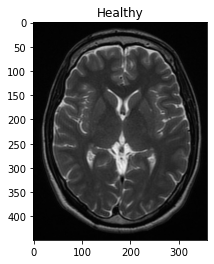

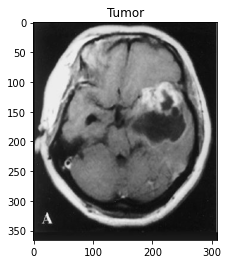

In [5]:
directory=os.listdir('./Cerveaux_Tumeurs/Entrainement')
for each in directory:
    plt.figure()
    currentFolder = './Cerveaux_Tumeurs/Entrainement/' + each
    for i, file in enumerate(os.listdir(currentFolder)[0:40]):
        fullpath =currentFolder+ '/' + file
        
        img=imread(fullpath)
        plt.title(each)
        plt.imshow(img)

On remarque que nos images ne sont pas de la même dimension. Pour pouvoir entrainer un réseau de neuronne il va falloir transformer ces images.

Healthy
Tumor


<BarContainer object of 2 artists>

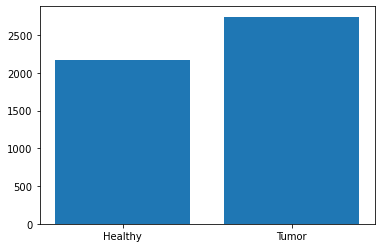

In [2]:
directory =os.listdir('./Cerveaux_Tumeurs/Entrainement')
mala = []
nombre = []
for maladie in directory:
    print(maladie)
    nombre_fichier = len(os.listdir('./Cerveaux_Tumeurs/Entrainement/'+ maladie))
    mala.append(maladie)
    print
    nombre.append(nombre_fichier)
    currentFolder = './Cerveaux_Tumeurs/Entrainement/' + maladie
plt.bar(mala, nombre)

In [3]:
nombre

[2168, 2743]

<BarContainer object of 2 artists>

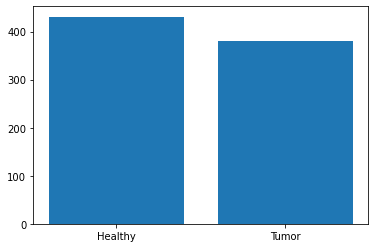

In [4]:
directory =os.listdir('./Cerveaux_Tumeurs/Validation')
mala = []
nombre = []
for maladie in directory:
    nombre_fichier = len(os.listdir('./Cerveaux_Tumeurs/Validation/'+ maladie))
    mala.append(maladie)
    
    nombre.append(nombre_fichier)
    currentFolder = './Cerveaux_Tumeurs/Validation/' + maladie
plt.bar(mala, nombre)

Il n'y a pas de déséquilibre dans notre ensemble de données d'entrainement et de validation

### Préparation des données 

- Nous allons utiliser les fonctions intégrés dans Keras pour convertir en tenseurs  nos images afin d'alimenter notre réseaux de neurones convolutifs.

- Nous allons dans un premier temps **augmenter nos données** grâce à des **générateurs**. Les générateus sont des fonctions dans lequel on stocke des variables, des éléments ou encore des images. 

- Les générateurs sont avantageux ils ne calculent pas la valeur de chaque élément. Ils ne font des calcules  uniquement lorsqu’on leur demande de le faire. On appelle  cela une évaluation paresseuse (Lazy Evaluation). Cela est très utile quand on a un nombre de données immense à calculer.

- La data augmentation consiste à augmenter la quantité de données disponibles.  En effet, cette méthode nous permet de créer de nouvelles images qui sont des variantes de l'image initiale. (En faisant des rotations, en redimensionant l'image.) 

- Nous pouvons utiliser le générateur **ImageDataGenerator** pour faire tout cela (Vous pouvez voir à quoi sert chaque paramètre dans les commentaires à coés du code). 

In [26]:
batch_size = 3  #Lot de données
img_height = 150
img_width = 150

In [27]:
# Data Augmentation 
entrainement_datagen = ImageDataGenerator(rescale=1./255, # On redimensionne l'image en la normalisant
                               rotation_range=10, # On fait pivoter l'image de 20 degrés
                               width_shift_range=0.05, # On augmente la largeur de la photo de 5% maximum
                               height_shift_range=0.05, # On modifie la hauteur de la photo de 5% maximum
                               shear_range=0.05, # shear = couper une partie de l'image (max 5%)
                               zoom_range=0.2, # On zoom de 10% maximum
                               horizontal_flip=True, # On autorise le basculement horizontal
                               fill_mode='nearest' # Pour remplir les pixels manquants avec la valeur remplie la plus proche
                              )

validation_datagen = ImageDataGenerator(rescale=1./255) #On n'a pas besoin de modifié les données de validation. 
                                                        #Il faut juste les normaliser


- Ici on peut voir en quoi consiste la data augmenation. La photo initiale est modifié pour créer d'autre images qui sont des variantes de celle-ci.

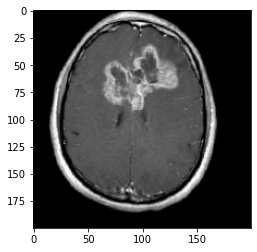

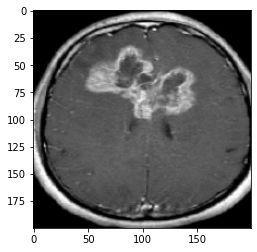

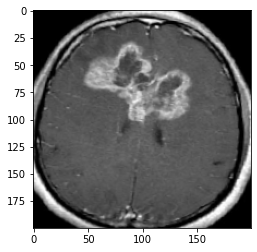

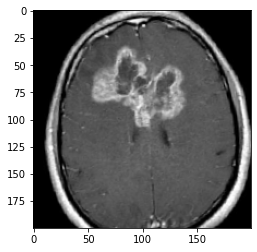

In [9]:
# Exemple Data Augmentation sur une image.

from keras.preprocessing import image


fnames = [os.path.join("./Cerveaux_Tumeurs/Entrainement/Tumor", fname) for 
     fname in os.listdir("./Cerveaux_Tumeurs/Entrainement/Tumor")]

img_path = fnames[3]
img = tf.keras.utils.load_img(img_path, target_size=(200, 200)) #Lit l'image et redimensionne celle-ci



x = tf.keras.utils.img_to_array(img) 
x = x.reshape((1,) + x.shape) 
i=0


for batch in entrainement_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(tf.keras.utils.img_to_array(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

- Après avoir inialisé un générateur, il faut charger les images dans celui-ci. La fonction **flow_from_directory** permet de chargés nos donnnées.

- Pour pouvoir utiliser la fonction **flow_from_directory** il faut organiser les images dans des sous-répertoires de la manière suivante: 

* Dossier de données d'images (Ici Animaux)
    * Classe 1
        * 0.jpg
        * 1.jpg
        * …
    * Classe 2
        * 0.jpg
        * 1.jpg
        * …
    * …
    * Classe n

In [28]:


train_ds = entrainement_datagen.flow_from_directory(
    './Cerveaux_Tumeurs/Entrainement',
    target_size=(img_height, img_width), #Redéfinit les dimensions de l'image
    batch_size=batch_size, #La taille du batch
    class_mode='binary') #Permet de choisir le type de labellisation que l'on veut


val_ds =  validation_datagen.flow_from_directory(
   './Cerveaux_Tumeurs/Validation',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 4911 images belonging to 2 classes.
Found 811 images belonging to 2 classes.


In [11]:
class_names = train_ds.class_indices
print(class_names)

{'Healthy': 0, 'Tumor': 1}


## Entrainement du modèle

On va maintenant créer notre réseaux neuronnes conventionnel en définissant le nombre de couche dont nous aurons besoin.

Rappel:



<p> <li> <a href=" https://www.kaggle.com/datasets/andrewmvd/animal-faces
">La couche de convolution </a>  est la composante clé des réseaux de neurones convolutifs, et constitue toujours au moins leur première couche. Son but est de repérer la présence d'un ensemble de features dans les images reçues en entrée. Elle permet  modèle de Deep Learning de détecter les zones qui caractérise l’image. Par exemple si nous avions une image de chat, elle aurait permi au modèle de trouver les endroits où se trouvent: </li>
<ul style="list-style-type: disc">
  <li>Les pattes</li>
</ul>

<ul style="list-style-type: disc">
  <li>Les oreilles</li>
</ul>

<ul style="list-style-type: disc">
  <li>Le museaux</li>
</ul>

</p>



La fonction **Conv2D** permetd’extraire les motifs et les tendances d’une donnée.


<img src="cnn2.png" title="Ptérodactyle en vol" />

- Les couches de Pooling  (MaxPool2D) permet de réduire le résultat obtenu. Il extrait des motifs, des tendances d’une donnée afin de garder  la valeur la plus importante de chaque motif des feature-maps. Le MaxPooling prend en entrée des feature-map pour en extraire la valeur max et garder  les informations importantes.


Source: https://inside-machinelearning.com/cnn-couche-de-convolution/#Quest-ce_quune_Couche_de_Convolution (Je vous conseil de lire cet article qui est très bien écrit)


In [34]:
from tensorflow.keras.models import Sequential
from  tensorflow.keras.regularizers import l2,l1,l1_l2
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D,BatchNormalization,RandomCrop
model = Sequential()

## Premier ensenble de couches

# Couche convolutive
model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(150, 150, 3), activation='relu',))
# Couche de Pooling
model.add(MaxPool2D(pool_size=(2, 2)))


## Second ensemble de couches
# Couche convolutive
model.add(Conv2D(128, (3, 3), activation='relu') )
# Couche de Pooling
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())



model.add(Dense(64, activation="relu"))
# Les couches Dropout aident à réduire l'overfitting en désactivant les neurones de façon aléatoire pendant l'entraînement.
# Ici nous demandons de désactiver aléatoirement 20% des neurones.
model.add(Dropout(0.2))

# La dernière est le classificateur, nous avons 2 classes possibles. On choisit la fonction d'activation sigmoid.
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=Adam(0.001),loss = BinaryCrossentropy(),metrics=['accuracy'])
#Résumé
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 36, 36, 128)      512       
 hNormalization)                                                 
                                                      

Voici un petit rappel sur les fonctions d'activation:
<img src="tableau11.png" title="Ptérodactyle en vol" />

######  Pour connaître le nombre de step par epoch pour que notre modèle s'entraine sur toute les images il faut faire le calcul suivant : steps_per_epoch= (data_samples/batch_size)

In [21]:
steps_per_epoch = len(train_ds)//batch_size #Batch_Size
validation_steps = len(val_ds)//batch_size
batch_size

8

In [35]:
from keras.callbacks import ModelCheckpoint
filepath = "./Modeles_Tumeur_CNN/model-Tumeur-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=2, save_best_only=False, mode='max')

In [36]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [37]:
from tensorflow import device,DeviceSpec
with device(DeviceSpec(device_type="GPU")):
    results = model.fit_generator(
      generator=train_ds,
      epochs=10,
      validation_data=val_ds
    #callbacks=[early_stop]
    ) 

Epoch 1/10


C:\Users\ghait\AppData\Local\Temp\ipykernel_17428\2542437865.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(


614/614 [==============================] - 125s 203ms/step - loss: 0.6858 - accuracy: 0.6646 - val_loss: 0.5666 - val_accuracy: 0.7004
Epoch 2/10
614/614 [==============================] - 134s 219ms/step - loss: 0.4745 - accuracy: 0.7626 - val_loss: 0.4278 - val_accuracy: 0.8187
Epoch 3/10
614/614 [==============================] - 138s 225ms/step - loss: 0.4294 - accuracy: 0.7986 - val_loss: 0.4358 - val_accuracy: 0.8039
Epoch 4/10
614/614 [==============================] - 151s 246ms/step - loss: 0.4025 - accuracy: 0.8131 - val_loss: 0.3985 - val_accuracy: 0.8261
Epoch 5/10
614/614 [==============================] - 128s 208ms/step - loss: 0.3743 - accuracy: 0.8298 - val_loss: 0.3696 - val_accuracy: 0.8348
Epoch 6/10
614/614 [==============================] - 125s 203ms/step - loss: 0.4074 - accuracy: 0.8165 - val_loss: 0.4091 - val_accuracy: 0.7990
Epoch 7/10
614/614 [==============================] - 125s 203ms/step - loss: 0.3626 - accuracy: 0.8231 - val_loss: 0.5669 - val_accura

##  Evaluation du modèle

<AxesSubplot:>

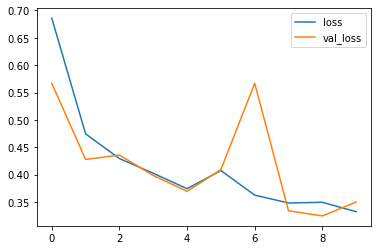

In [39]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

<AxesSubplot:>

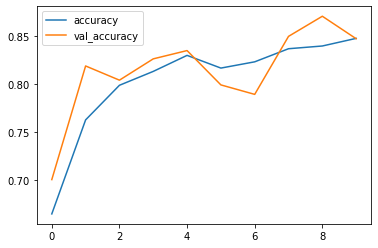

In [40]:
losses[['accuracy','val_accuracy']].plot()

- Les valeurs "loss" n'ont fait que décroître (sauf pour l'epoch 6) durant l'entrainement de notre modèle que ce soit pour les données de validations ou les données d'entrainement. 
- Les valeurs de "l'accuracy" n'ont fait qu'augmenter (sauf pour l'epoch 6) durant l'entrainement de notre modèle que ce soit pour les données de validations ou les données d'entrainement. 
- Nous avons "à priori" un bon modèle.
- Si la valeur du loss diminue pour les données d'entrainement mais qu'elle augmente pour les données de validation alors nous pouvons parler d'OverFitting. (SurApprentissage)
- L'accuracy et la valeur loss ne suffisent pas à dire si le modèle est bon ou non. 


In [41]:
#Pour sauvegarder le modèle.
from tensorflow.keras.models import load_model
model.save('Tumeur_Modele_Finale.h5')

In [61]:
validation_datagen = ImageDataGenerator(rescale=1./255) 
val_ds =  validation_datagen.flow_from_directory(
   './Cerveaux_Tumeurs/Validation',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 811 images belonging to 2 classes.


In [42]:
from tensorflow import keras
#model = keras.models.load_model("./Modele_Tumeur4/model-Tumeur-26.hdf5")
from sklearn.metrics import classification_report,confusion_matrix
pred_probabilities = model.predict(val_ds)
predictions = pred_probabilities > 0.5
print(classification_report(val_ds.classes,predictions))

102/102 [==============================] - 4s 37ms/step
              precision    recall  f1-score   support

           0       0.55      0.59      0.57       431
           1       0.49      0.45      0.47       380

    accuracy                           0.52       811
   macro avg       0.52      0.52      0.52       811
weighted avg       0.52      0.52      0.52       811



In [31]:
model.evaluate(val_ds)

102/102 [==============================] - 5s 50ms/step - loss: 0.4674 - accuracy: 0.8422


[0.4673811197280884, 0.8421701788902283]

- Le recall c'est le nombre de vrai positif divisé par la somme des Vrai positif  et faux négatif.  Le "recall" correspond au taux d’individus positifs détectés par le modèle. Parmis les patients qui n'ont pas de tumeur  combien ont été correctement prédit? D'après notre raport 59% des patients prédit "healthy" ont été prédit correctement. 

- La précision c'est le  nombre de vrai positif sur la somme des vrais positifs et faux positifs. Elle correspond au taux de prédictions correctes parmi les prédictions positives.  Parmis les patients à qui l'ont ne prédit pas de tumeur   combien  sont vraiment sans risque? Ici, 55% des patients prédits en "bonne santé" le sont réélement. 

- Qu'elle est la meilleur metrics à utiliser? Cela dépend vraiment de la situation. Dans notre situation, il vaut mieux ne pas utiliser ce modèle. En effet, il faudrait un recall et une précision de 99% pour la variable "Tumeur". Dans le domaine médicale il faut être très précis

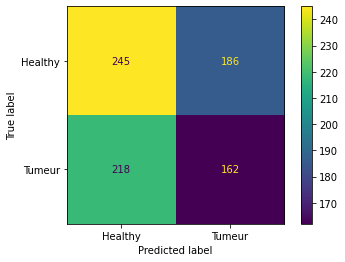

In [63]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(val_ds.classes,predictions), display_labels=['Healthy','Tumeur'])
disp.plot()
plt.show()

### Comment améliorer notre modèle?

- On pourrait modifier, supprimer ou rajouter des couches de neuronnes 
- Augmenter le nombre d'epoch
- Modifier les hyperparamètres
- On a surement pas assez de données
- Utiliser la technique du **transfer learning**

## Transfer Learning

<li> <a href="https://datascientest.com/transfer-learning
">Le Transfer Learning</a> désigne l’ensemble des méthodes qui permettent de transférer les connaissances acquises à partir de la résolution de problèmes donnés pour traiter un autre problème. </li>

En d'autre mots, c'est l'utilisation d'un modèles pré-entraînés comme point de départ afin d'accélérer l'apprentissage d'un nouveau modèle.

In [41]:
from keras import models
from keras import layers
from tensorflow.keras.models import Sequential
from  tensorflow.keras.regularizers import l2,l1,l1_l2
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D,BatchNormalization,RandomCrop
from keras.applications import VGG16,MobileNetV2,ResNet50
from keras.layers import Conv2D,MaxPool2D,GlobalAveragePooling2D

conv_base = ResNet50(weights='imagenet',
                     pooling='max',
                  include_top=False,
                  input_shape=(150, 150, 3))
model = models.Sequential()
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
model.compile(optimizer=Adam(0.001),loss = BinaryCrossentropy(),metrics=['accuracy'])


In [18]:
from tensorflow import device,DeviceSpec
with device(DeviceSpec(device_type="GPU")):
    results = model.fit_generator(
      generator=train_ds,
      epochs=10,
      validation_data=val_ds
    #callbacks=[early_stop]
    ) 

Epoch 1/10


C:\Users\ghait\AppData\Local\Temp\ipykernel_15944\2542437865.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(


614/614 [==============================] - 119s 184ms/step - loss: 0.5148 - accuracy: 0.8790 - val_loss: 0.1998 - val_accuracy: 0.9211
Epoch 2/10
614/614 [==============================] - 112s 182ms/step - loss: 0.1549 - accuracy: 0.9405 - val_loss: 0.1724 - val_accuracy: 0.9359
Epoch 3/10
614/614 [==============================] - 112s 182ms/step - loss: 0.1214 - accuracy: 0.9542 - val_loss: 0.4143 - val_accuracy: 0.8533
Epoch 4/10
614/614 [==============================] - 112s 182ms/step - loss: 0.1088 - accuracy: 0.9587 - val_loss: 0.2401 - val_accuracy: 0.9026
Epoch 5/10
614/614 [==============================] - 112s 182ms/step - loss: 0.0981 - accuracy: 0.9650 - val_loss: 0.1119 - val_accuracy: 0.9593
Epoch 6/10
614/614 [==============================] - 112s 182ms/step - loss: 0.0915 - accuracy: 0.9686 - val_loss: 0.2347 - val_accuracy: 0.9149
Epoch 7/10
614/614 [==============================] - 112s 182ms/step - loss: 0.0701 - accuracy: 0.9754 - val_loss: 0.3175 - val_accura

<AxesSubplot:>

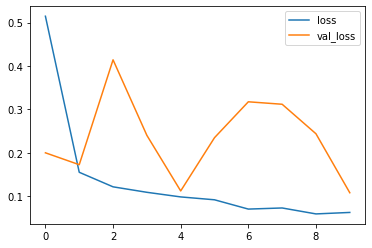

In [19]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

<AxesSubplot:>

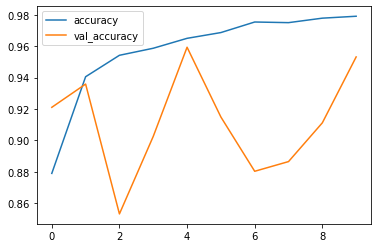

In [20]:
losses[['accuracy','val_accuracy']].plot()

In [22]:
#Pour sauvegarder le modèle.
from tensorflow.keras.models import load_model
model.save('Tumeur_Modele_Finale.h5')

In [43]:
validation_datagen = ImageDataGenerator(rescale=1./255) 
val_ds =  validation_datagen.flow_from_directory(
   './Cerveaux_Tumeurs/Validation',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 811 images belonging to 2 classes.


In [24]:
from tensorflow import keras
from sklearn.metrics import classification_report,confusion_matrix
pred_probabilities = model.predict(val_ds)
predictions = pred_probabilities > 0.5
print(classification_report(val_ds.classes,predictions))

16/16 [==============================] - 2s 111ms/step
              precision    recall  f1-score   support

           0       0.65      0.59      0.62        86
           1       0.26      0.30      0.28        40

    accuracy                           0.50       126
   macro avg       0.45      0.45      0.45       126
weighted avg       0.52      0.50      0.51       126



- On ne voit pas d'amélioration avec ResNet.